# TP 4 : Stéganographie

Ce TP de multimédia est réalisé en Python3, à l'aide de la librairie scikit-image. Les tableaux utilisés par cette librairie pour manipuler les images (ndarray) proviennent de la librairie numpy. La documentation de ces deux librairies vous sera donc bien utile.

**Note:** Tous les scripts de ce TP travaillent par défaut sur une image d'example (Lenna), mais vous pouvez test avec d'autres images afin de teser les algorithmes dans diverses situations.


## Stéganographie ?

La stéganographie ou tatouage d'images est un ensemble de techniques permettant de cacher des informations dans une image (le secret). Dans ce TP on va cacher du texte et des images dans des images. Mais il est bien entendu possible de cacher toute donnée binaire.


## Stéganographie dans le domaine spatial

Pour cette première partie on va s'intéresser à une technique simple de stéganographie opérant directement sur les valeur des pixels. Le script ci-dessous fournit une implémentation simple de cette technique.

<IPython.core.display.Javascript object>


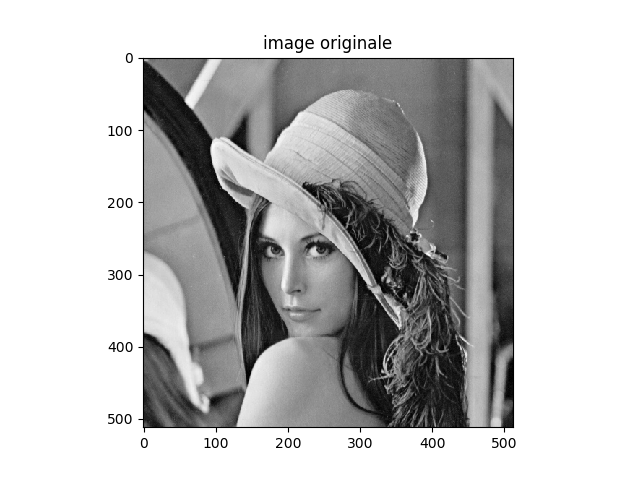

Taille du secret (nb d'octets) : 89926


<IPython.core.display.Javascript object>


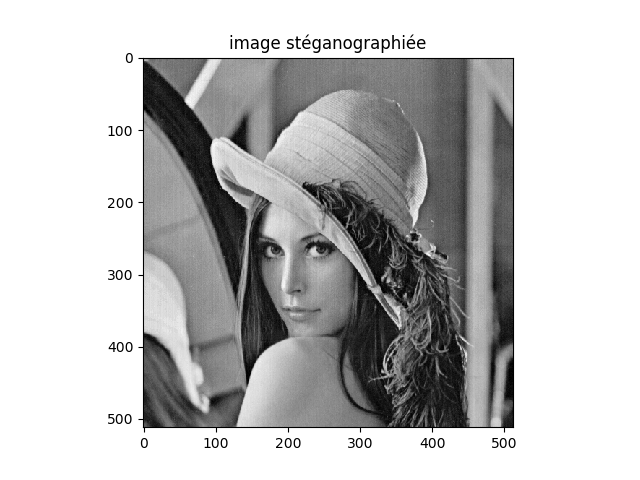

<IPython.core.display.Javascript object>


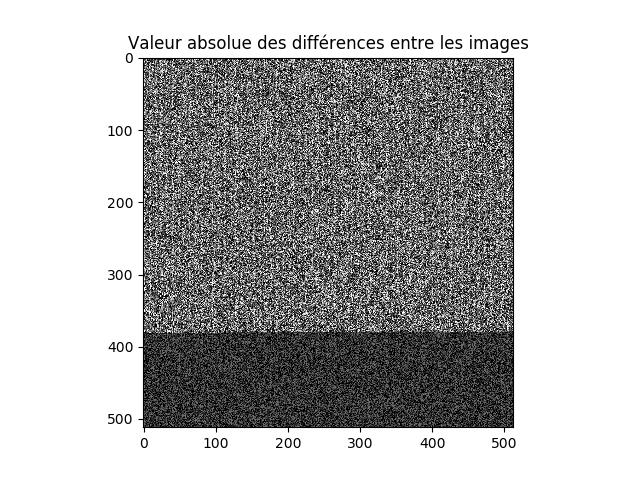

Taille de l'image (nb d'octets) : 262144
64 premiers octets (originale):  [1111011 10011011 10101010 10101110 10101101 10101011 10100101 10001010
 1110111 1110100 1101101 1110010 1110001 1101011 1110101 1101100 1110110
 1110011 1111011 1111001 1111000 1111101 1110100 1111001 1111000 1110111
 1111110 1111010 1111000 1111001 1110100 1111101 1101111 1110000 1110110
 1110111 1110111 1110110 1111101 1111011 1111000 1110110 1111011 1110111
 1110001 1111110 1110101 1110101 1111000 1110010 1110100 1110110 1110010
 1110110 1110101 1110101 1110001 1110011 1110100 1110011 1111011 1110110
 1110101 1110101]
64 premiers octets (steganographiée):  [1111000 10011110 10101110 10101000 10101110 10101000 10100000 10001100
 1110000 1110110 1101110 1110000 1110000 1101010 1110000 1101110 1110000
 1110110 1111110 1111000 1111110 1111110 1110010 1111100 1111000 1110010
 1111110 1111000 1111000 1111010 1110000 1111000 1101000 1110110 1110110
 1110010 1110100 1110100 1111010 1111000 1111000 1110110 1111110 111

In [2]:
# Pour afficher le contenu complet de chaque résultat (pas de scroll)
%matplotlib notebook

from skimage import io
from skimage import measure
from matplotlib import pyplot as plt
import numpy as np

# pour que l'affichage des matrices soit facilement lisible (plus tard dans le TP)
np.set_printoptions(suppress=True)
np.set_printoptions(precision=0)
np.set_printoptions(threshold=1000)

'''
SteganographyException
'''
class SteganographyException(Exception):
    pass

'''
Class for LSB based steganography
'''
class SpaceSteg():
    def __init__(self, im):
        self.image = im
        self.width = im.shape[1]
        self.height = im.shape[0]
        self.size = self.width * self.height
        if len(im.shape) == 2:
            self.nbchannels = 1
            self.image = self.image.reshape((self.height,self.width,self.nbchannels))
        else:
            self.nbchannels = im.shape[2]
    
        self.maskONEValues = [1,2,4,8,16,32,64,128]
        #Mask used to put one ex:1->00000001, 2->00000010 .. associated with OR bitwise
        self.maskONE = self.maskONEValues.pop(0) #Will be used to do bitwise operations

        self.maskZEROValues = [254,253,251,247,239,223,191,127]
        #Mak used to put zero ex:254->11111110, 253->11111101 .. associated with AND bitwise
        self.maskZERO = self.maskZEROValues.pop(0)
        
        self.curwidth = 0 #Current width position
        self.curheight = 0 #Current height position
        self.curchan = 0 #Current channel position

    def getImage(self):
    # Save the image using the given filename
        if self.nbchannels == 1:
            return self.image.reshape((self.height, self.width))
        else:
            return self.image.reshape((self.height, self.width, self.nbchannels))


    def putBinaryValue(self, bits): #Put the bits in the image
        for c in bits:
            val = self.image[self.curheight,self.curwidth, self.curchan]
            if int(c) == 1:
                val = int(val) | self.maskONE #OR with maskONE
            else:
                val = int(val) & self.maskZERO #AND with maskZERO

            self.image[self.curheight,self.curwidth, self.curchan] = val
            self.nextSpace() #Move "cursor" to the next space
            
    def nextSpace(self):#Move to the next slot were information can be taken or put
        if self.curchan == self.nbchannels-1: #Next Space is the following channel
            self.curchan = 0
            if self.curwidth == self.width-1: #Or the first channel of the next pixel of the same line
                self.curwidth = 0
                if self.curheight == self.height-1:#Or the first channel of the first pixel of the next line
                    self.curheight = 0
                    if self.maskONE == 128: #Mask 1000000, so the last mask
                        raise SteganographyException("Image filled")
                    else: #Or instead of using the first bit start using the second and so on..
                        self.maskONE = self.maskONEValues.pop(0)
                        self.maskZERO = self.maskZEROValues.pop(0)
                else:
                    self.curheight +=1
            else:
                self.curwidth +=1
        else:
            self.curchan +=1  

    def readBit(self): #Read a single bit int the image
        val = self.image[self.curheight,self.curwidth, self.curchan]
        val = int(val) & self.maskONE
        self.nextSpace()
        if val > 0:
            return "1"
        else:
            return "0"

    def readByte(self):
        return self.readBits(8)

    def readBits(self, nb): #Read the given number of bits
        bits = ""
        for i in range(nb):
            bits += self.readBit()
        return bits

    def byteValue(self, val):
        return self.binValue(val, 8)

    def binValue(self, val, bitsize): #Return the binary value of an int as a byte
        binval = bin(val)[2:]
        if len(binval) > bitsize:
            raise SteganographyException("binary value larger than the expected size")
        while len(binval) < bitsize:
            binval = "0"+binval
        return binval

    def hideBin(self, filename):
        f = open(filename,'rb')
        bin = f.read()
        l = len(bin)
        print("Taille du secret (nb d'octets) :", l)
        if self.width*self.height*self.nbchannels < l+64:
            raise SteganographyException("Carrier image not big enough to hold all the datas to steganography")
        self.putBinaryValue(self.binValue(l, 64))
        for byte in bin:
            self.putBinaryValue(self.byteValue(byte))

    def unhideBin(self):
        l = int(self.readBits(64),2)
        output = ""
        for i in range(l):
            output += chr(int(self.readByte(),2))
        return output


    
'''    
Programme principal
'''
sourceimage = "lena.jpg"
secretfile = "secret-maxi.txt"

# Insertion du secret dans l'image
carrier = io.imread(sourceimage)
plt.figure(1)
plt.title("image originale")
plt.imshow(carrier, cmap='gray')

steg = SpaceSteg(carrier)
steg.hideBin(secretfile)
hidden = steg.getImage()
plt.figure(2)
plt.title("image stéganographiée")
plt.imshow(hidden, cmap='gray')

# Quelques infos supplémentaires
carrier = io.imread(sourceimage)
diff = abs(carrier.astype(int)-hidden.astype(int))
plt.figure(3)
plt.title("Valeur absolue des différences entre les images")
plt.imshow(diff, cmap='gray')
print("Taille de l'image (nb d'octets) :", carrier.size)
np.set_printoptions(formatter={'int':lambda x:"{0:b}".format(int(x))})
print("64 premiers octets (originale): ",carrier[0,0:64].astype(int))
print("64 premiers octets (steganographiée): ",hidden[0,0:64].astype(int))
np.set_printoptions(formatter=None)
print("Difference dans les 64 premiers octets : ",carrier[0,0:64].astype(int)-hidden[0,0:64].astype(int))
print("Difference après l'octet 64 (1ere ligne) : ",carrier[0,64:].astype(int)-hidden[0,64:].astype(int))
print("Différence max : ",diff.max())
print("PSNR : ",measure.compare_psnr(carrier,hidden))

# Récupération du secret
steg = SpaceSteg(hidden)
binsecret = steg.unhideBin()
if len(binsecret) > 256:
    print("Secret : ", binsecret[0:256], "[...]") # on affiche seulement le début du secret
else:
    print("Secret : ", binsecret)
    


**Question 1:** Testez l'algorithme avec "secret-nano.txt", "secret-mini.txt", "secret.txt" et "secret-maxi.txt". A l'aide des résultats affichés (et en regardant le code si besoin), expliquez comment fonctionne l'algorithme.

**Réponse 1:** 

**Question 2:** En variant la taille du secret et en regardant les valeurs de PSNR obtenues (ainsi que votre propre jugement), déterminer la capacité maximum de cet algorithme permettant de garder une qualité d'image acceptable.

**Réponse 2:**

**Question 3:** D'après votre compréhension de l'algorithme utilisé:
1. Est-il facile de détecter qu'une image a été stéganographiée ? Expliquez.
2. Si cela est possible peut on facilement récupérer les informations cachées dans l'image ? Expliquez.
3. Comment pourrait on améliorer la confidentialité des données cachées ?

**Réponse 3:** 

**Question 4:** Testez quelques transformations simples sur l'image stéganographiée. 
1. Cette algorithme est il robuste aux transformations ?
2. Y a-t-il un moyen simple d'améliorer les choses ?

In [10]:
from skimage import transform

ratio=0.95
# ici on fait un changement d'échelle, mais vous devez tester d'autre transformations (rotation, flou, sauvegarde en JPEG, etc.)
smaller = transform.resize(hidden, ( int(carrier.shape[0]*ratio), int(carrier.shape[1]*ratio)))
steg = SpaceSteg(smaller)
binsecret = steg.unhideBin()
print(binsecret) # si rien ne s'affiche, alors on a perdu le secret...

**Réponse 4:**

## Stéganographie dans le domaine fréquentiel

Nous allons maintenant tenter d'appliquer (naivement) la même technique que précédemment, mais aux coefficients DCT qu'on pourrait obtenir en compressant une image au format JPEG (comme dans le TP du même nom).

Coefficents du 1er bloc de l'image (originale): [[ 133.  116.  117.  127.  124.  128.  127.  128.]
 [ 158.  137.  123.  128.  126.  128.  128.  128.]
 [ 110.  124.  132.  128.  129.  128.  128.  128.]
 [ 134.  127.  126.  128.  128.  128.  128.  128.]
 [ 128.  131.  129.  128.  128.  128.  128.  128.]
 [ 127.  127.  128.  129.  128.  128.  128.  128.]
 [ 127.  128.  128.  128.  128.  128.  128.  128.]
 [ 129.  128.  128.  128.  128.  128.  128.  128.]]
Taille du secret (nb d'octets) : 89926
Coefficents du 1er bloc de l'image (stéganographiée): [[ 128.  118.  118.  120.  126.  128.  120.  132.]
 [ 152.  142.  127.  128.  124.  134.  128.  134.]
 [ 104.  127.  135.  128.  134.  135.  134.  129.]
 [ 128.  126.  127.  134.  128.  128.  132.  132.]
 [ 128.  133.  135.  132.  128.  128.  133.  133.]
 [ 120.  127.  135.  130.  128.  135.  128.  135.]
 [ 120.  135.  135.  130.  129.  130.  128.  135.]
 [ 128.  134.  135.  134.  128.  130.  132.  130.]]


<IPython.core.display.Javascript object>


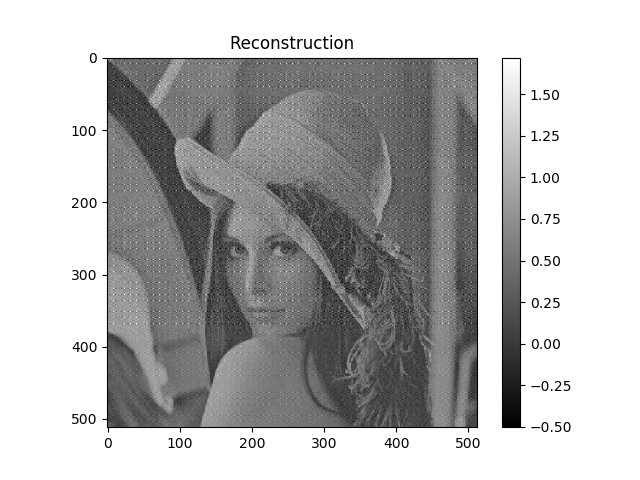

Secret :  Lorem ipsum dolor sit amet, consectetur adipiscing elit. Phasellus feugiat massa ut dolor tincidunt vestibulum. Aenean vehicula pulvinar est, non consectetur mi. Sed sagittis eu sem in consequat. Aliquam erat volutpat. Proin posuere dui nec auctor congue.  [...]


In [3]:
from skimage import transform
from skimage import color
import numpy as np
from scipy import fftpack

sourceimage = "lena.jpg"
secretfile = "secret-maxi.txt"

#Au cas ou
#zigzagorder = [ 1,  9,  2,  3,  10, 17, 25, 18, 11, 4,  5,  12, 19, 26, 33, 41, 34, 27, 20, 13, 6,  7,  14, 21, 28, 35, 42, 49, 57, 50, 43, 36, 29, 22, 15, 8,  16, 23, 30, 37, 44, 51, 58, 59, 52, 45, 38, 31, 24, 32, 39, 46, 53, 60, 61, 54, 47, 40, 48, 55, 62, 63, 56, 64]

# lecture de l'image source
image = io.imread(sourceimage)

# on la redimensionne à un multiple de 8 pixels
image = transform.resize(image,(image.shape[0]//8*8,image.shape[1]//8*8))
width=image.shape[1]
height=image.shape[0]

# calcul des coefficients DCT de chaque bloc 8x8
greyimg=color.rgb2grey(image)
dctimg=np.zeros(greyimg.shape)

for y in range(0,height,8):
    for x in range(0, width,8):
        bloc=greyimg[y:y+8,x:x+8]
        dctimg[y:y+8,x:x+8]=128+(32*fftpack.dct(fftpack.dct(bloc,norm='ortho').T,norm='ortho').T).astype(int)
        dctimg[y,x] = (dctimg[y,x]-128)

# Stéganographie       
print("Coefficents du 1er bloc de l'image (originale):",dctimg[0:8,0:8])
steg = SpaceSteg(dctimg)
steg.hideBin(secretfile)
print("Coefficents du 1er bloc de l'image (stéganographiée):",dctimg[0:8,0:8])

# reconstruction (on décompresse)
compressedimg=np.zeros(greyimg.shape)

for y in range(0,height,8):
    for x in range(0, width,8):
        bloc=dctimg[y:y+8,x:x+8]-128
        bloc[0,0] = (bloc[0,0]+128)
        compressedimg[y:y+8,x:x+8]=fftpack.idct(fftpack.idct(bloc/32,norm='ortho').T,norm='ortho').T

plt.figure(4)
plt.imshow(compressedimg,cmap='gray')
plt.title("Reconstruction")
plt.colorbar()

# on extrait le secret
steg = SpaceSteg(dctimg)
binsecret = steg.unhideBin()
if len(binsecret) > 256:
    print("Secret : ", binsecret[0:256], "[...]") # on affiche seulement le début du secret
else:
    print("Secret : ", binsecret)



**Question 5:** Testez l'algorithme avec différentes taille de secret.
1. La qualité obtenue après DCT -> steganographie -> inverse DCT est-elle satisfaisante ? Expliquez
2. Que devrait on faire pour que le tatouage soit plus discret ?
3. Est-ce que la capacité de stockage (d'un secret) de l'algorithme sera différente ? Expliquez
4. A votre avis, ce tatouage dans le domaine fréquentiel est il plus robuste aux différentes transformations? Expliquez et testez si-possible.

**Réponse 5**:

**Question bonus:** Modifiez la fonction `nextSpace` et / ou le script ci-dessus afin de rendre le tatouage dans le domaine fréquentiel plus discret.

In [ ]:
# Insérer ici le code modifié pour la question bonus

*Crédits : une partie du code source de ce TP est inspiré du code suivant : https://github.com/RobinDavid/LSB-Steganography*